# Clusters
This notebook details the pipeline for clustering.

In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load the data 
When loading the chord dataset, we can choose whether to keep sections in major or minor key, or both.

In [2]:
from load_data import load_chord_data_sentences, all_composers

In [3]:
# Optional parameter for load_chord_data: key_mode = 'both'/'major'/'minor'
chord_sentences = load_chord_data_sentences(all_composers, key_mode='major')

In [10]:
# Print chord frequencies
chord_freq = {}
for sentence in chord_sentences:
    for chord in sentence:
        if chord not in chord_freq:
            chord_freq[chord] = 0
        chord_freq[chord] += 1

print(sorted(chord_freq.items(), key=lambda kv: kv[1]))

[('#III:MIN', 1), ('##I:MAJ', 1), ('#V:AUG', 1), ('bbIII:MAJ', 1), ('bII:DIM', 1), ('VI:AUG', 1), ('#VII:MIN', 1), ('bI:AUG', 2), ('bbVII:AUG', 2), ('bIV:AUG', 2), ('#VI:MIN', 2), ('##I:DIM', 2), ('##II:DIM', 3), ('bV:MIN', 3), ('bVI:DIM', 3), ('bII:AUG', 4), ('bV:AUG', 4), ('bbVII:MIN', 4), ('##V:DIM', 4), ('bbVII:MAJ', 5), ('bVII:AUG', 5), ('#III:MAJ', 5), ('#V:MIN', 6), ('#III:DIM', 6), ('II:AUG', 7), ('bI:MIN', 7), ('#I:MIN', 7), ('bVII:DIM', 8), ('bVI:MIN', 8), ('bIII:DIM', 8), ('#II:MIN', 8), ('III:AUG', 8), ('bII:MIN', 10), ('#VI:MAJ', 11), ('bIII:AUG', 12), ('bI:MAJ', 14), ('bIV:MAJ', 17), ('#VII:DIM', 18), ('IV:DIM', 19), ('IV:AUG', 25), ('bIII:MIN', 25), ('#IV:MIN', 29), ('bV:MAJ', 33), ('bVI:AUG', 39), ('#V:MAJ', 41), ('I:DIM', 44), ('#VI:DIM', 46), ('##IV:DIM', 46), ('#II:MAJ', 48), ('#I:MAJ', 54), ('V:DIM', 64), ('bVII:MIN', 72), ('V:AUG', 84), ('VI:DIM', 116), ('VII:MIN', 117), ('bII:MAJ', 141), ('#IV:MAJ', 211), ('I:AUG', 229), ('bIII:MAJ', 288), ('bVI:MAJ', 294), ('#II:

## Apply Word2Vec

In [4]:
from gensim.models import Word2Vec

In [69]:
# Ignore words with a lower frequency frequency than this
min_count = 50
# Size of the embedding space
size = 5
# Neighborhood of the focus word to study
window = 3
# 0 for CBOW, 1 for skip-gram
sg = 0
# Number of iterations (epochs)
iter = 500

# The first argument has to be a list of lists of words
w2v_model = Word2Vec(chord_sentences, min_count=min_count, size=size, window=window, sg=sg, iter=iter)

In [88]:
w2v_model.wv.vocab.keys()

dict_keys(['I:MAJ', 'V:MAJ', 'IV:MAJ', '#IV:DIM', 'II:MAJ', 'VI:MIN', 'bVII:MAJ', 'VII:DIM', 'III:MAJ', 'VI:MAJ', 'II:MIN', '#I:DIM', 'V:MIN', 'III:DIM', 'II:DIM', 'IV:MIN', '#V:DIM', 'VII:MAJ', 'III:MIN', 'I:MIN', 'VII:MIN', 'bIII:MAJ', 'bVI:MAJ', '#II:DIM', 'VI:DIM', 'I:AUG', 'V:AUG', 'bVII:MIN', 'bII:MAJ', '#IV:MAJ', 'V:DIM', '#I:MAJ'])

## Isolate clusters, reduce dimensionality and visualise
We want to visualise the chord vectors and to find similarities among them.  
We isolate clusters, then we plot the dimensionality-reduced word vectors, highlighting the clusters by colour.

### Isolate clusters: K-means / Agglomerative

In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from dimred_cluster import cluster_keyed_vec

#### Hyperparameter selection for k-means: n_clusters

In [20]:
from matplotlib import pyplot as plt

2  4  3  6  3  3  3  3  3  5  3  3  3  2  2  3  3  2  3  

Text(0, 0.5, 'K-means loss')

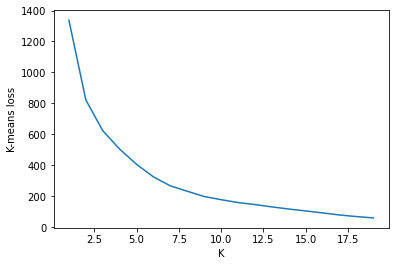

In [86]:
# The possible values of k
ks = range(1, 20)

inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, tol=1e-10, n_init=100)
    wv_clus, clusters = cluster_keyed_vec(w2v_model.wv, kmeans, relabel=False)
    print(kmeans.n_iter_, ' ', end='')
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias)
plt.xlabel('K')
plt.ylabel('K-means loss')
# Hmmm, not that useful...

In [81]:
# Main hyperparameter: number of clusters
#n_clusters = 2

#kmeans = KMeans(n_clusters=n_clusters)
agglomerative = AgglomerativeClustering(n_clusters=None, affinity='cosine', distance_threshold=0.2, linkage='complete')
wv_clus, clusters, relabelling = cluster_keyed_vec(w2v_model.wv, agglomerative, relabel=True)

print(wv_clus, '\n')
for label in sorted(clusters.keys()):
    print(label, ':', clusters[label])
print('\n', relabelling, '\n')

{'I:MAJ': 6, 'V:MAJ': 6, 'IV:MAJ': 0, '#IV:DIM': 9, 'II:MAJ': 3, 'VI:MIN': 4, 'bVII:MAJ': 5, 'VII:DIM': 7, 'III:MAJ': 4, 'VI:MAJ': 0, 'II:MIN': 0, '#I:DIM': 0, 'V:MIN': 5, 'III:DIM': 5, 'II:DIM': 1, 'IV:MIN': 1, '#V:DIM': 7, 'VII:MAJ': 3, 'III:MIN': 10, 'I:MIN': 8, 'VII:MIN': 3, 'bIII:MAJ': 2, 'bVI:MAJ': 1, '#II:DIM': 4, 'VI:DIM': 2, 'I:AUG': 11, 'V:AUG': 12, 'bVII:MIN': 1, 'bII:MAJ': 2, '#IV:MAJ': 8, 'V:DIM': 2, '#I:MAJ': 13} 

0 : ['IV:MAJ', 'VI:MAJ', 'II:MIN', '#I:DIM']
1 : ['II:DIM', 'IV:MIN', 'bVI:MAJ', 'bVII:MIN']
2 : ['bIII:MAJ', 'VI:DIM', 'bII:MAJ', 'V:DIM']
3 : ['II:MAJ', 'VII:MAJ', 'VII:MIN']
4 : ['VI:MIN', 'III:MAJ', '#II:DIM']
5 : ['bVII:MAJ', 'V:MIN', 'III:DIM']
6 : ['I:MAJ', 'V:MAJ']
7 : ['VII:DIM', '#V:DIM']
8 : ['I:MIN', '#IV:MAJ']
9 : ['#IV:DIM']
10 : ['III:MIN']
11 : ['I:AUG']
12 : ['V:AUG']
13 : ['#I:MAJ']

 {0: 0, 9: 1, 3: 2, 7: 3, 4: 4, 2: 5, 5: 6, 10: 7, 1: 8, 11: 9, 8: 10, 13: 11, 6: 12, 12: 13} 



In [74]:
from visual_clusters import plot_dendrogram

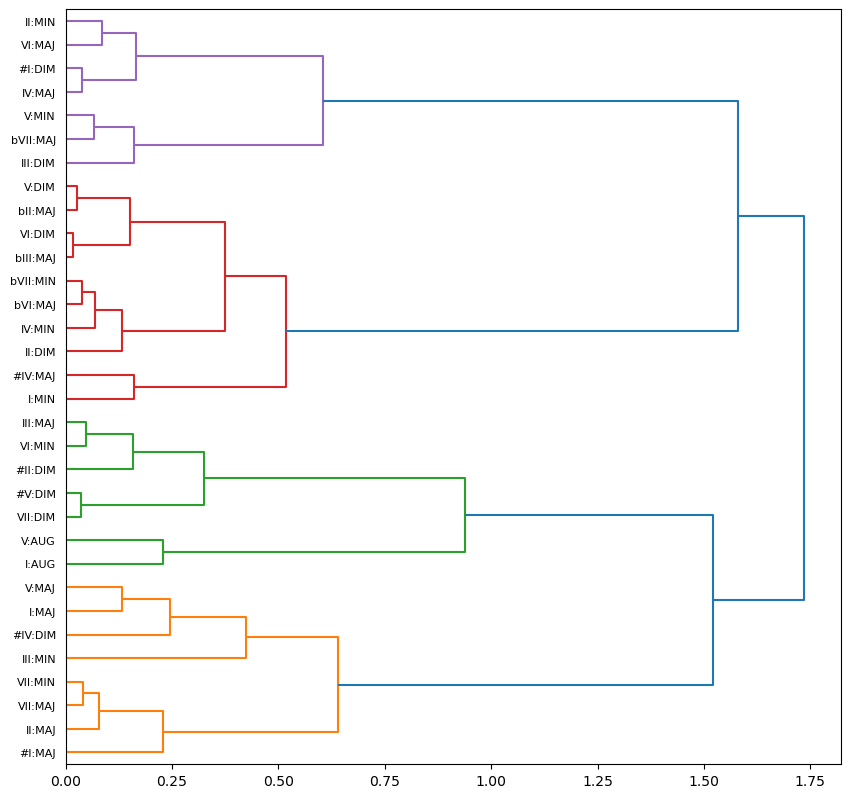

In [75]:
# Only works if agglomerative was constructed with n_clusters=None and distance_threshold=0
plot_dendrogram(agglomerative, leaf_label_func=lambda id : clusters[id][0], orientation='right')

### Reduce dimensionality: PCA / TSNE / Isomap

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from dimred_cluster import dimred_keyed_vec

In [82]:
n_components = 2

pca = PCA(n_components=n_components)
#tsne = TSNE(n_components=n_components, learning_rate=100, n_iter=50000, n_iter_without_progress=10000)
#isomap = Isomap(n_components=n_components, metric='euclidean')
wv_red = dimred_keyed_vec(w2v_model.wv, pca.fit_transform, comps_to_keep=[0,1])

In [83]:
print(pca.components_[0])
print(pca.components_[1])
print(pca.explained_variance_ratio_)

[-0.43671483 -0.04638913 -0.65539662 -0.51642612 -0.3329978 ]
[-0.28180137  0.64439921  0.22183639  0.29167014 -0.60914267]
[0.4699737  0.27347241]


### Visualise
Scatter dimensionality-reduced points.  
The shape of the marker indicates the key mode of the section containing the chord (major/minor/unspecified).  
The colour of the marker indicates the cluster label.

In [84]:
from visual_clusters import visual_chord_vectors_clusters

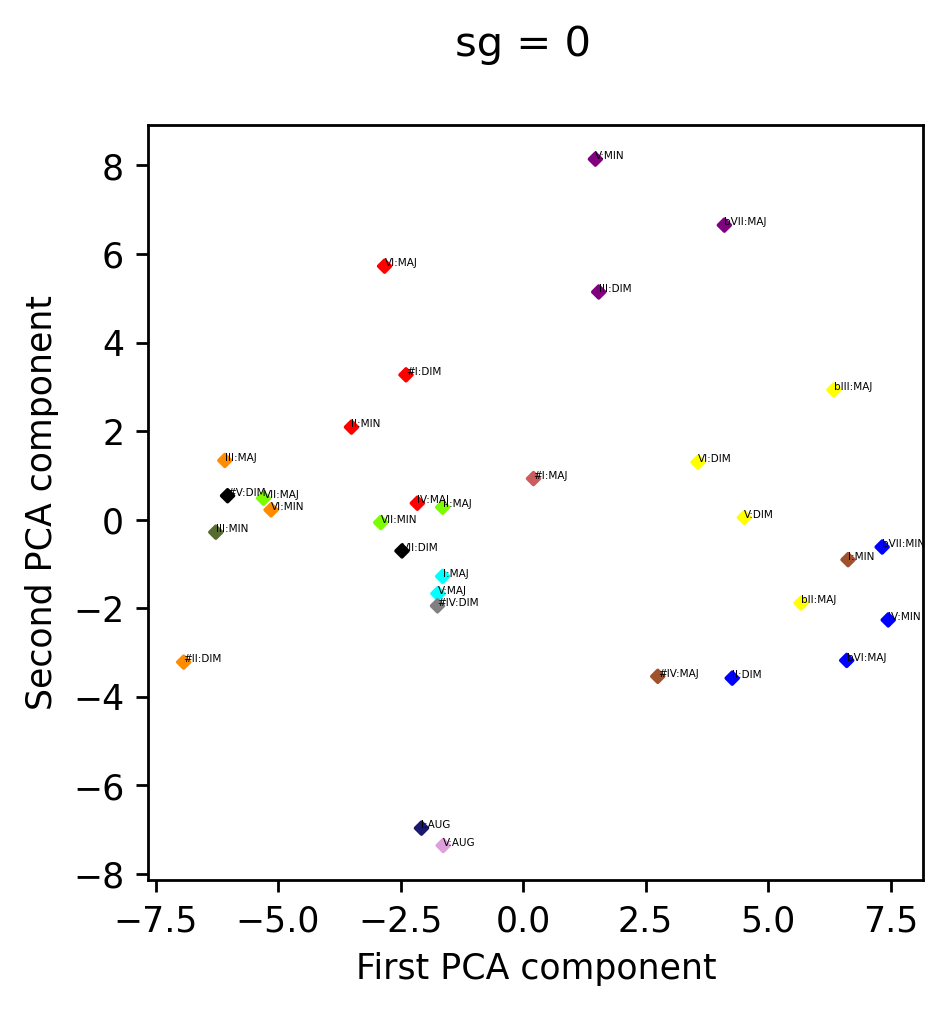

In [85]:
visual_chord_vectors_clusters(wv_red=wv_red, wv_clus=wv_clus, dimred_method='PCA', 
                             plot_title='sg = 0', 
                             chord_types_to_label=[''], chord_types_not_to_label=[], 
                             marker_size=6, label_size=3, remove_key_mode=False, figsize=(4, 4), dpi=250)

## Investigate similarities

In [11]:
w2v_model.wv.similarity('I:MIN', 'V:MAJ')

0.1922745

In [14]:
from visual_clusters import print_similarities

In [80]:
print_similarities(w2v_model, chord_types_to_print_sim=[''])

#I:DIM: (IV:MAJ, 0.962), (VI:MAJ, 0.919), (II:MIN, 0.835), (III:DIM, 0.813),
#I:MAJ: (II:MAJ, 0.918), (VII:MIN, 0.898), (VII:MAJ, 0.771), (#IV:MAJ, 0.757),
#II:DIM: (VI:MIN, 0.858), (III:MAJ, 0.843), (#IV:DIM, 0.841), (#V:DIM, 0.775),
#IV:DIM: (#II:DIM, 0.841), (I:MAJ, 0.765), (VII:MAJ, 0.763), (V:MAJ, 0.754),
#IV:MAJ: (I:MIN, 0.839), (bVI:MAJ, 0.765), (#I:MAJ, 0.757), (V:MAJ, 0.664),
#V:DIM: (VII:DIM, 0.965), (III:MAJ, 0.948), (VI:MIN, 0.903), (IV:MAJ, 0.844),
I:AUG: (V:AUG, 0.772), (II:DIM, 0.510), (VII:DIM, 0.481), (#II:DIM, 0.432),
I:MAJ: (V:MAJ, 0.868), (#IV:DIM, 0.765), (#II:DIM, 0.697), (V:AUG, 0.664),
I:MIN: (IV:MIN, 0.861), (#IV:MAJ, 0.839), (VI:DIM, 0.804), (bVI:MAJ, 0.798),
II:DIM: (bII:MAJ, 0.928), (bVI:MAJ, 0.921), (bVII:MIN, 0.880), (IV:MIN, 0.868),
II:MAJ: (VII:MIN, 0.944), (VII:MAJ, 0.923), (#I:MAJ, 0.918), (III:MIN, 0.717),
II:MIN: (VI:MAJ, 0.915), (IV:MAJ, 0.856), (#I:DIM, 0.835), (VI:MIN, 0.757),
III:DIM: (bVII:MAJ, 0.918), (V:MIN, 0.839), (#I:DIM, 0.813), (VI:MAJ, 0